# Trying out an LDA model to apply topic modelling to MEAs

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [34]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pickle
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pprint
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
nlp = spacy.load('en_core_web_trf')
lemmatizer = nlp.get_pipe("lemmatizer")

In [194]:
stop_word_list = ["transcript","respondent","ohio","division", "department", "commerce","financial","revised","code","institutions","chapter","codified","institution","heshe","rc","oh","mortgage","fact","notice","act","chapters","arizona","january","february","april","march","may","june","july","august","september","october","november","december","dfi","ce","pursuant","realize","days","result","investigation","indicate","state"]

In [195]:
len(stop_word_list)

43

In [196]:
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}

In [197]:
# Load data
df = pd.read_csv("Standardized Data/Final_cleaned.csv")

In [199]:
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

In [168]:
sample_text = df.loc[1,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

['charge', 'responsibility', 'enforce', 'codify', 'revise', 'responsibility', 'protect', 'public', 'proscribed', 'practice', 'find', 'order', 'necessary', 'appropriate', 'public', 'interest', 'consistent', 'purpose', 'send', 'certified', 'mail', 'intent', 'revoke', 'certificate', 'registration', 'opportunity', 'hear', 'fund', 'business', 'address', 'record', 'hold', 'hearing', 'matter', 'accordance', 'daysjuly', 'hearing', 'officer', 'issue', 'report', 'recommendation', 'determine', 'violate', 'list', 'fictitious', 'creditor', 'false', 'information', 'loan', 'document', 'convert', 'borrower', 'creditor', 'money', 'cause', 'customer', 'sign', 'blank', 'loan', 'document', 'charge', 'excess', 'fee', 'interfere', 'investigation', 'order', 'page', 'hearing', 'officer', 'report', 'recommend', 'superintendent', 'revoke', 'broker', 'certificate', 'registration', 'file', 'objection', 'hearing', 'officer', 'report', 'recommendation', 'carefully', 'consider', 'hearing', 'officer', 'report', 'reco

In [268]:
text = df["Text"].sample(n=200, random_state = 1)
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/200 [00:00<?, ?it/s]

In [270]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example

print(trigram_mod[bigram_mod[text_list[1]]])

['conduct', 'find', 'follow', 'attest_swear_statement', 'information_provide', 'criminal_background', 'loan', 'officer', 'license', 'application', 'submit', 'complete', 'truthful', 'attempt_obtain', 'loan', 'officer', 'license_provide_untruthful', 'information', 'criminal_background', 'finding_list_determine', 'respondents', 'action_list', 'character_general', 'fitness_command_confidence_public', 'warrant_belief', 'business_operate_honestly_fairly', 'compliance_purpose_action_list', 'paragraph', 'b_violate_prohibit', 'loan', 'officer', 'applicant_substantial_misrepresentation', 'registration', 'license', 'application', 'opportunity', 'hearing', 'page', 'action_list_paragraph', 'b_violate_prohibit', 'loan', 'officer', 'applicant_false_misleading', 'statement_material_omission_statement', 'require', 'law', 'action_list_paragraph', 'b_violate_prohibit', 'loan', 'officer', 'applicant', 'engage', 'conduct_constitute_improper', 'fraudulent_dishonest_dealing']


In [271]:
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]

In [263]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

In [ ]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in grammed_list]

In [222]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=words)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [264]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=2, limit=20, step=3)

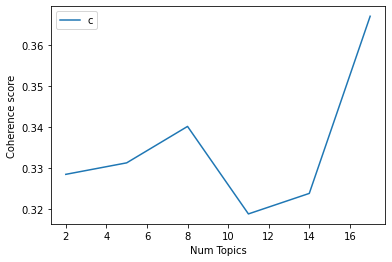

In [265]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [266]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3284
Num Topics = 5  has Coherence Value of 0.3312
Num Topics = 8  has Coherence Value of 0.3401
Num Topics = 11  has Coherence Value of 0.3188
Num Topics = 14  has Coherence Value of 0.3238
Num Topics = 17  has Coherence Value of 0.367


In [248]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=6 
                                           )

In [249]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.648300682771347

Coherence Score:  0.4670602855533237


In [267]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_list[2], corpus, words)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.018012  0.000040       1        1  24.260204
2     -0.064843 -0.022645       2        1  22.228936
1      0.040982 -0.038993       3        1  17.343074
5      0.045926 -0.004662       4        1  10.930470
6     -0.040099  0.033626       5        1   8.199168
4     -0.012167  0.008599       6        1   6.709345
0     -0.012303 -0.032814       7        1   6.592066
7      0.024492  0.056848       8        1   3.736736, topic_info=            Term        Freq       Total Category  logprob  loglift
23       officer  770.000000  770.000000  Default  30.0000  30.0000
50          loan  792.000000  792.000000  Default  29.0000  29.0000
16       license  645.000000  645.000000  Default  28.0000  28.0000
105      renewal  163.000000  163.000000  Default  27.0000  27.0000
38   application  430.000000  430.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
76          hold    2.874462   75.685370   Topic8  -5.2951   0.0162
161        renew    2.551966   65.742197   Topic8  -5.4141   0.0381
224      hearing    3.139186  156.033905   Topic8  -5.2070  -0.6192
66          deny    2.861726  171.177386   Topic8  -5.2995  -0.8043
80          page    2.407941   87.015862   Topic8  -5.4722  -0.3004

[564 rows x 6 columns], token_table=      Topic      Freq                         Term
term                                              
1462      1  0.554594                           31
33        2  0.567240                  action_list
549       1  0.119742        action_list_paragraph
549       2  0.598712        action_list_paragraph
549       3  0.059871        action_list_paragraph
...     ...       ...                          ...
1294      5  0.405952  write_report_recommendation
1294      6  0.135317  write_report_recommendation
632       3  0.644705                      writing
1342      1  0.446747                      written
1342      5  0.223374                      written

[1462 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 6, 7, 5, 1, 8])

In [93]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [254]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9926,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline","[settlement, agreement, enter, basis, following, stipulation_admission_understanding, empower, renew, applicant, broker, dertificate, registration, find, thing_applicants, operation, manager, comply, complete, minimum, hour, approve, continue, education, prior, calendar, year, authorize, refuse, renew, applicant, broker, certificate, registration, find, applicant, violate, fail, comply, provision, section, revise, rule_adopt, section, law_applicable_business, conduct, certificate, registration, require, operation, manager, complete, hour, approve, continue, education, calendar, year, broker, certificate, registration_expire_effort, renew, certificate, submit, renewal, application, renewal, application, remain_pende, admit, fail, comply, requirement, calendar, year, f, fail, comply, authority, refuse, renew, broker, certificate, registration, enter, settlement, agreement, lieu, formal, proceeding, deny, renewal, application, broker, certificate, registration, basis, admit, noncompliance, expressly_reserve, right, ...]"
1,1,3.0,0.9938,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline","[settlement, agreement, enter, basis, follow, stipulation_admission_understanding, empower, renew, applicant, broker, certificate, registration, find, thing_applicants, operation, manager, comply, complete, minimum, hour, approve, continue, education, prior, calendar, year, page, authorize, refuse, renew, applicant, broker, certificate, registration, find, applicant, violate, fail, comply, provision, section, revise, rule_adopt, section, law_applicable_business, conduct, certificate, registration, require, operation, manager, complete, hour, approve, continue, education, calendar, year_31st_d, year, law, impose, requirement, operation, manager, extend, deadline, broker, certificate, registration_expire_effort, renew, certificate, submit, renewal, application, renewal, application, remain_pende, admit_extension_time, grant, comply, requirement, fail, complete, require, credit, hour, extend, deadline, record, complete, hour, approve, expiration, extend, deadline, h, fail, comply, authority, refuse, ...]"
2,2,3.0,0.9938,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline","[settlement, agreement, enter, basis, follow, stipulation_admission_understanding, empower, renew, applicant, broker, certificate, registration, find, thing_applicants, operation, manager, comply, complete, minimum, hour, approve, continue, education, prior, calendar, year, page, authorize, refuse, renew, applicant, broker, certificate, registration, find, applicant, violate, fail, comply, provision, section, revise, rule_adopt, section, law_applicable_business, conduct, certificate, registration, require, operation, manager, complete, hour, approve, continue, education, calendar, year_31st_d, year, law, impose, requirement, operation, manager, extend, deadline, broker, certificate, registration_expire_effort, renew, certificate, submit, renewal, application, renewal, application, remain_pende, admit_extension_time, grant, comply, requirement, fail, complete, require, credit, hour, extend, deadline, record, complete, hour, approve, expiration, extend, deadline, h, fail, comply, authority, refuse, ...]"
3,3,3.0,0.9926,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline","[settlement, agreement, enter, basis, follow, stipulation_admission_understanding, empower, renew, applicant, broker, certificate, registration, find, thing_applicants, operation, manager, comply, complete, minimum, hour, approve, continue, education, prior, calendar, year, authorize, refuse, renew, applicant, broker, certificate, registration, find, applicant, violate, fail, page, comply, provision, section, revise, rule_adopt, section, law_applicable_business

In [255]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9836,"officer, loan, license, application, renew, complete, comply, settlement, applicant, approve","[denial, loan, officer, license, application, order, submit, loan, officer, license, application, issue, intent, deny, application, notify, right, hearing, matter_request, hearing, thereto_administrative, hearing_hold_accordance, revise, hearing, officer, file_write, report_recommendation_recommend, deny, application, copy_report, recommendation_letter, explain, right, submit, write_objection_report, mail_certified, mail, timely, file_objection, consideration, hearing, officer, report_recommendation_confirm, approve, recommendation_accordingly, application, loan, officer, license, deny]"
1,1.0,0.9954,"loan, officer, license, fail, comply, certificate, require, applicant, renew, application","[provide, untruthful, information, loan, officer, license, application, course, loan, officer, license, application, supply, false_misleading, statement, document, concern, disposition, charge, aggravated, trafficking, drug, plead_guilty, convict, attempt, trafficking, marijuana, attempted, possession, criminal, tool, municipal_court, convict, drug, abuse, intent, revoke, loan, officer, license, opportunity, hearing, page, finding_list, determine_prove, honest_truthful, good_reputation_basis, believe_commit_criminal_offense, involve, drug_trafficking, section, action_list_paragraph, character_general, fitness_command, confidence_public, warrant_belief, business, operate_honestly, fairly_compliance, purpose, action_list_paragraph, character_general, fitness_command, confidence_public, warrant_belief, business, operate_honestly, fairly_compliance, purpose, action_list_paragraph, character_general, fitness_command, confidence_public, warrant_belief, business, operate_honestly, fairly_compliance, purpose, action_list_paragraph, iv, character_general, fitness_command, confidence_public, warrant_belief, business, operate_honestly, fairly_compliance, purpose, action_list_paragraph, violate, prohibit, loan, officer, applicant, substantial_misrepresentation, registration, license, application, action_list_paragraph, violate, ...]"
2,2.0,0.9912,"loan, settlement, agreement, hour, complete, officer, license, comply, applicant, fail","[settlement, agreement, enter, basis, follow, stipulation, information, admission_understanding, require, loan, officer, complete, hour, approve, continue, education, calendar, year, 31st, page, year, law, impose, requirement, operation, manager, extend, deadline, record, complete, hour, approve, expiration, extend, deadline, admit_extension_time, grant, comply, requirement, fail, complete, require, credit, hour, extend, deadline, authorize, revoke, licensee, loan, officer, license, find, licensee, violate, fail, comply, provision, section, revise, fail, comply, authority, revoke, loan, officer, license, enter, settlement, agreement, lieu, formal, proceeding, revoke, loan, officer, license, basis, admit, noncompliance, expressly_reserve, right, institute, formal, proceeding, base, violation, noncompliance, provision, specifically, address, occur_effective_date, settlement, agreement]"
3,3.0,0.9949,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline","[settlement, agreement, enter, basis, following, stipulation_admission_understanding, empower, renew, applicant, broker, certificate, registration, find, thing, applicant, comply, require, applicant, operation, manager, successfully, complete, operation, manager, examination_mandate, require, applicant, operation, manager, complete, minimum, hour, approve, continue, education, prior, calendar, year, page, exam, late, authorize, refuse, renew, applicant, broker, certificate, registration, find, applicant, violate, fail, comply, provision, section, revise, rule_adopt, section, law_applicable_business, conduct, certificate, registration, require, operation, manager, successfully, complete, operat

In [258]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.head()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",14.0,0.0741
1.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",23.0,0.1217
2.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",32.0,0.1693
3.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",111.0,0.5873
4.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",8.0,0.0423
...,...,...,...,...
184.0,2.0,"loan, settlement, agreement, hour, complete, officer, license, comply, applicant, fail",NaN,NaN
185.0,1.0,"loan, officer, license, fail, comply, certificate, require, applicant, renew, application",NaN,NaN
186.0,2.0,"loan, settlement, agreement, hour, complete, officer, license, comply, applicant, fail",NaN,NaN
187.0,3.0,"hour, comply, officer, loan, complete, agreement, applicant, renew, fail, deadline",NaN,NaN
